<a href="https://colab.research.google.com/github/LarrySnyder/ASJ/blob/main/hero-villain-ML-training/Hero_Villain_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hero-Villain Image Classification

This notebook contains code to classify images as depicting either heroes or villains. The training data were collected from students in class using an online survey tool. The images were downloaded from the internet.

The image classification ML code is based on the tutorial at https://www.tensorflow.org/tutorials/images/classification




---
> 👓 **Note:** This notebook is part of the *Algorithms and Social Justice* course at Lehigh University, Profs. Larry Snyder and Suzanne Edwards.
---

### Preliminary Python Stuff

In [ ]:
# Imports.
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

If you want to run this notebook, you will have to replace the directory paths below with the directories where your data are stored. If you are using Google Drive, you'll also have to [mount your drive](https://stackoverflow.com/a/52300696/3453768).

In [ ]:
# Paths to directories we will use.
training_dir = '/content/drive/MyDrive/Colab Notebooks/ASJ/datasets/training_data'
testing_dir = "/content/drive/MyDrive/Colab Notebooks/ASJ/datasets/testing_data"

### Training the Model

The next bunch of cells are boilerplate stuff to train an image-recognition ML model using TensorFlow. 

In [ ]:
# Define parameters.
batch_size = 16
img_height = 180
img_width = 180

In [ ]:
# Training/validation split.
train_ds = tf.keras.utils.image_dataset_from_directory(
    training_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 578 files belonging to 2 classes.
Using 463 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    training_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 578 files belonging to 2 classes.
Using 115 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['hero', 'villain']


The code below shows some images and the labels assigned to them by students. If you run the cell multiple times, you'll get different batches of images each time.

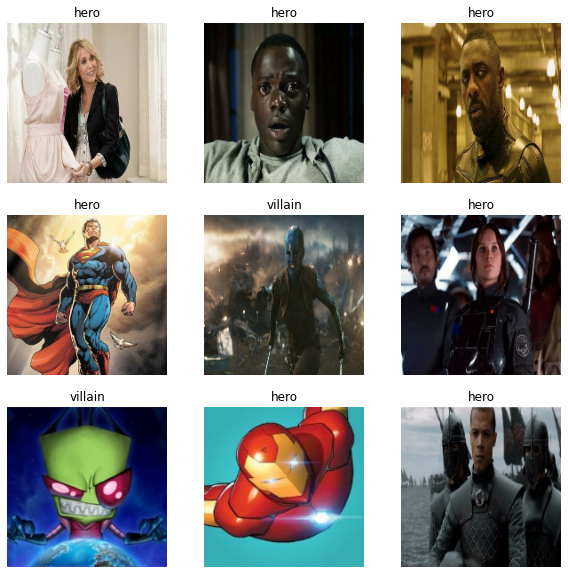

In [ ]:
# Visualize.
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

More boilerplate ML stuff...

In [ ]:
# Configure dataset for performance.
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Standardize the data.
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

In [ ]:
# Data augmentation.
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal",
                          input_shape=(img_height,
                                       img_width,
                                       3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

In [ ]:
# Build model, with dropout.
num_classes = len(class_names)
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")
])

In [ ]:
# Compile.
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

This is the step where the model is actually **trained.** (It should take a couple of minutes to run, if you're running it yourself.)

In [ ]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
29/29 [==============================] - 30s 976ms/step - loss: 0.8474 - accuracy: 0.5443 - val_loss: 0.7067 - val_accuracy: 0.4696
Epoch 2/10
29/29 [==============================] - 20s 700ms/step - loss: 0.7111 - accuracy: 0.4838 - val_loss: 0.6976 - val_accuracy: 0.4783
Epoch 3/10
29/29 [==============================] - 18s 633ms/step - loss: 0.6822 - accuracy: 0.5486 - val_loss: 0.6948 - val_accuracy: 0.5391
Epoch 4/10
29/29 [==============================] - 18s 633ms/step - loss: 0.6797 - accuracy: 0.5637 - val_loss: 0.7020 - val_accuracy: 0.5130
Epoch 5/10
29/29 [==============================] - 18s 624ms/step - loss: 0.6745 - accuracy: 0.5896 - val_loss: 0.6818 - val_accuracy: 0.5913
Epoch 6/10
29/29 [==============================] - 20s 697ms/step - loss: 0.6577 - accuracy: 0.6048 - val_loss: 0.6834 - val_accuracy: 0.6000
Epoch 7/10
29/29 [==============================] - 21s 716ms/step - loss: 0.6579 - accuracy: 0.5896 - val_loss: 0.6799 - val_accuracy: 0.5913

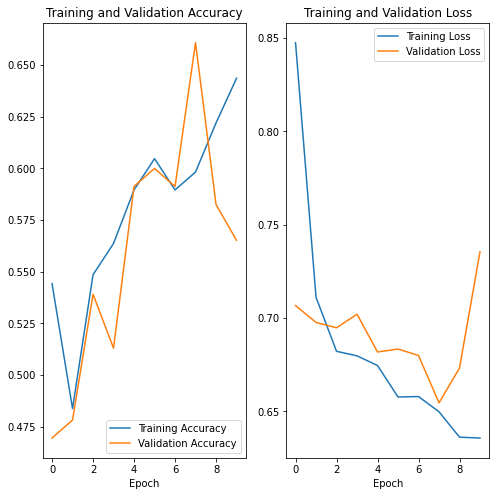

In [ ]:
# Visualize training results.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.show()

The (validation) accuracy of our trained model is around 55-60%. That's not great—it's barely better than just randomly guessing "hero" or "villain" for each image. But it's also not a surprise, since we have a very small training data set.

### Testing the Model

Now we'll use our trained model to classify new images that the model has never seen before. First we'll show a few images, along with their predicted and actual categories.

Found 27 files belonging to 2 classes.


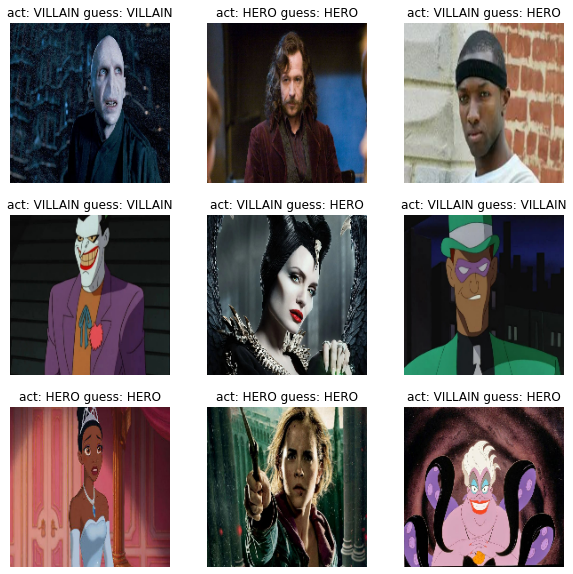

In [ ]:
# Classify new data.

test_ds = tf.keras.utils.image_dataset_from_directory(
    testing_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    for i in range(9):
        # Predict class for this image.
        img_array = tf.keras.utils.img_to_array(images[i])
        img_array = tf.expand_dims(img_array, 0)
        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])

        # Plot image.
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        title = f'act: {class_names[labels[i]].upper()} guess: {class_names[np.argmax(score)].upper()}' #' conf: {100 * np.max(score):.1f}%'
        plt.title(title)
        plt.axis("off")


Then we'll calculate the overall testing accuracy for our model, i.e., the percentages of images in the testing dataset that the model correctly categorized as "hero" or "villain".

In [ ]:
# Calculate test accuracy for the whole testing dataset.
test_result = model.evaluate(test_ds)
dict(zip(model.metrics_names, test_result))

2/2 [==============================] - 0s 134ms/step - loss: 0.7848 - accuracy: 0.4815


{'loss': 0.7848402857780457, 'accuracy': 0.48148149251937866}

48%—that's terrible! But again, not a surprise.

### Things to Think About

Our model did a terrible job of classifying new images. That's largely because the training dataset was tiny (a few hundred images), and because we set the code to do a pretty quick and sloppy job of training. We'd need thousands, or more, images to really train our model. (But this exercise was really about how ML *labeling* works, not about how to train an accurate model.)

Here are some questions you might want to think about:

* Who was doing the training in our experiment? What biases might have creeped into the training?
* What red flags should we be on the lookout for in the results?
* "Hero" and "villain" are subjective terms. How does this complicate the ML model? What would happen if the training dataset contained images of complex characters like Walter White (*Breaking Bad*) or Siobhan Roy (*Succession*)? Or Donald Trump or Joe Biden?
* Suppose we could get great training data and do a great job of training the model, so that it reliably categorized images of heroes and villains. What are some potential uses for this model? What are some ways the model could potentially be *mis*used?